In [1]:
from qiskit import pulse, circuit, transpile, assemble, schedule, IBMQ, QuantumCircuit, quantum_info as qi 
import qiskit
from qiskit.visualization import plot_gate_map, plot_error_map
from qiskit.visualization.pulse_v2 import draw
from qiskit.pulse import ShiftPhase, GaussianSquare, Drag, ControlChannel, MeasureChannel, DriveChannel, Play
import numpy as np
from qiskit.tools import job_monitor
from copy import deepcopy
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [50]:
account_provider = IBMQ.load_account()
provider_opts = {'hub': 'ibm-q-ncsu', 'group': 'nc-state', 'project':'noiseanderror'}

# target backend
backend_name = 'ibmq_jakarta'

provider = IBMQ.get_provider(**provider_opts)
backend = provider.get_backend(backend_name)

# backend information
config = backend.configuration()
defaults = backend.defaults()
properties = backend.properties()

# instruction schedule map
inst_map = defaults.instruction_schedule_map

ibmqfactory.load_account:WARNING:2021-11-09 11:27:00,799: Credentials are already in use. The existing account in the session will be replaced.


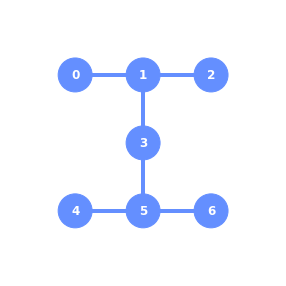

In [3]:
qubits = plot_gate_map(backend)
qubits

In [38]:
def extract_cr_params(cx_sched):
    cr_params = {}
    for time, inst in cx_sched.instructions:
        if isinstance(inst, Play):
            if isinstance(inst.pulse, GaussianSquare):
                if isinstance(inst.operands[1], ControlChannel):
                    cr_params["duration"] = inst.pulse.duration
                    cr_params["width"] = inst.pulse.width
                    cr_params["sigma"] = inst.pulse.sigma
                    cr_params["cr_amp"] = inst.pulse.amp
                    cr_params["channel"] = inst.channel
    return cr_params
                    

def build_cr_schedule(backend, qc, qt, cr_params, cr_name):
    
    with pulse.build(backend=backend, default_alignment="left", name="cr_schedule") as cross_resonance:
        pulse.play(GaussianSquare(
            duration=cr_params["duration"],
            amp=cr_params["cr_amp"],
            width=cr_params["width"],
            sigma=cr_params["sigma"],
            name=cr_name
        ),
        pulse.control_channels(qc, qt)[0],
    )
        if not np.isclose(cr_params["cancel_amp"], 0.0):
            pulse.play(GaussianSquare(
                duration=cr_params["duration"],
                amp=cr_params["cancel_amp"],
                width=cr_params["width"],
                sigma=cr_params["sigma"],
        ),
        pulse.drive_channel(qt),
    )
        else:
            pulse.delay(cr_params["duration"], pulse.drive_channel(qt))
        pulse.delay(cr_params["duration"], pulse.drive_channel(qc))
        
    return cross_resonance

def build_cr_circuit(gate):
    
    cr_circuit = QuantumCircuit(2)
    cr_circuit.append(gate, [0, 1])

    
    return cr_circuit

def build_amp_experiment_circuits(backend, qc, qt, amps, cr_params, rotary=False):
    
    circ_list = []
    
    inst_map_list = []
    for amplitude in amps:
        
        new_inst_map = deepcopy(inst_map)
    

        cr_p_gate = circuit.Gate(
            "cr_p_gate",
            num_qubits=2,
            params=[amplitude],
        )
        
        
        cr_m_gate = circuit.Gate(
            "cr_m_gate",
            num_qubits=2,
            params=[-amplitude],
        )
        
        exp_circ = QuantumCircuit(2)

        ## add control state prep when needed
        
        
        exp_circ.rz(-np.pi/2, 0)
        exp_circ.x(0)
        exp_circ.compose(other=build_cr_circuit(cr_p_gate), qubits=[0, 1], inplace=True)
        exp_circ.x(0)
        exp_circ.compose(other=build_cr_circuit(cr_m_gate), qubits=[0, 1], inplace=True)
#         exp_circ.x(0)
        
        exp_circ.metadata={
            "qubits": (qc, qt)
        }

        if rotary is True:
            cr_params['cancel_amp'] = amplitude
            
        cr_params["phi"] = 0
        cr_params['cr_amp'] = amplitude * np.exp(-1j*cr_params["phi"])
#         print(cr_params["cr_amp"], cr_params['phi'])
        exp_circ.add_calibration(gate=cr_p_gate,
                                qubits=[qc,qt],
                                schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_p"))
        
        cr_params['phi'] = cr_params['phi'] + np.pi
        cr_params['cr_amp'] = amplitude * np.exp(-1j*cr_params["phi"])
#         print(cr_params["cr_amp"], cr_params['phi'])
        exp_circ.add_calibration(gate=cr_m_gate,
                                qubits=[qc,qt],
                                schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_m"))
        exp_circ.measure_active()
        
#         new_inst_map.add('cr_gate', qubits=[qc, qt], schedule=build_cr_schedule(backend, qc, qt, cr_params))
        
        circ_list.append(exp_circ)
        inst_map_list.append(new_inst_map)
    return circ_list, inst_map_list

def build_phase_experiment_circuits(backend, qc, qt, phases, cr_params, rotary=False):
    
    circ_list = []
    inst_map_list = []
    amp = cr_params['cr_amp']
    for phase in phases:
        new_inst_map = deepcopy(inst_map)
    
        cr_p_gate = circuit.Gate(
            "cr_p_gate",
            num_qubits=2,
            params=[phase],
        )
        
        cr_m_gate = circuit.Gate(
            "cr_m_gate",
            num_qubits=2,
            params=[phase],
        )
        exp_circ = QuantumCircuit(2)
        exp_circ.rz(-np.pi/2, 0)
        exp_circ.x(0)
        exp_circ.compose(other=build_cr_circuit(cr_p_gate), qubits=[0, 1], inplace=True)
        exp_circ.x(0)
        exp_circ.compose(other=build_cr_circuit(cr_m_gate), qubits=[0, 1], inplace=True)
        exp_circ.barrier(0, 1)
        exp_circ.sdg(1)
        exp_circ.h(1)
        
        
        exp_circ.metadata={
            "qubits": (qc, qt)
        }
        
        if rotary is True:
            cr_params['cancel_amp'] = cr_params["cr_amp"]
        
        cr_params['cr_amp'] = amp * np.exp(-1j*phase)
        print(cr_params['cr_amp'])
        exp_circ.add_calibration(gate=cr_p_gate,
                                qubits=[qc,qt],
                                schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_p"))

        phase = phase + np.pi
        cr_params['cr_amp'] = amp * np.exp(-1j*phase)
        print(cr_params['cr_amp'])
        exp_circ.add_calibration(gate=cr_m_gate,
                                qubits=[qc,qt],
                                schedule=build_cr_schedule(backend, qc, qt, cr_params, cr_name="cr_m"))
        exp_circ.measure_active()
        
        circ_list.append(exp_circ)
        inst_map_list.append(new_inst_map)
        
    return circ_list, inst_map_list
        
def expectation_val(count_dict, mem_ind):

    expv = 0
    for key, val in count_dict.items():
        if key[::-1][mem_ind] == '1':
#             print(key, val)
            expv -= val
        else:
            expv += val
#     print(expv)
    return expv / sum(count_dict.values())

In [5]:
q1, q2 = 0, 1
mem_ind = 0 if q1 > q2 else 1

# IBM's cross resonance gate
This is what IBM's cross-resonance gate looks like - extracted from the CX pulse schedule, and with the rotary tones not shown.

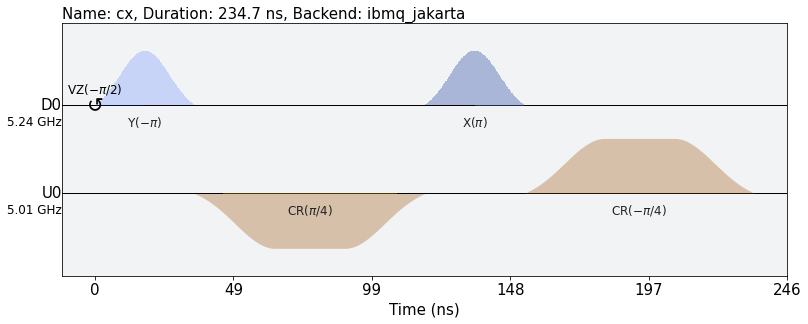

In [6]:
cx_sched = inst_map.get('cx', qubits=[q1, q2])
draw(cx_sched, backend=backend, disable_channels=[DriveChannel(q2)])

In [7]:
for time, inst in cx_sched.instructions:
    print(inst)

ShiftPhase(1.5707963267948966, DriveChannel(0))
ShiftPhase(1.5707963267948966, ControlChannel(1))
Play(Drag(duration=160, amp=(-3.641543730718857e-17-0.19823640760499228j), sigma=40, beta=-0.9822975593177294, name='Ym_d0'), DriveChannel(0), name='Ym_d0')
Play(Drag(duration=160, amp=(0.09599346417151727+0.002192330190773967j), sigma=40, beta=-0.9595783962023514, name='X90p_d1'), DriveChannel(1), name='X90p_d1')
Play(GaussianSquare(duration=368, amp=(0.11222035341506578+0.002722991037731407j), sigma=64, width=112, name='CR90p_d1_u0'), DriveChannel(1), name='CR90p_d1_u0')
Play(GaussianSquare(duration=368, amp=(-0.004982605402084058-0.7589986843947967j), sigma=64, width=112, name='CR90p_u0'), ControlChannel(0), name='CR90p_u0')
Play(Drag(duration=160, amp=(0.19823640760499228+0j), sigma=40, beta=-0.9822975593177294, name='Xp_d0'), DriveChannel(0), name='Xp_d0')
Play(GaussianSquare(duration=368, amp=(-0.11222035341506578-0.0027229910377313932j), sigma=64, width=112, name='CR90m_d1_u0'), Dri

In [8]:
cr_params = extract_cr_params(cx_sched)
cr_params["cancel_amp"] = 0.0
cr_params["phi"] = 0
# print(cr_params)

max_cr_amplitude = 1.0
num_amps = 70
cr_amps = np.linspace(-max_cr_amplitude, max_cr_amplitude, num_amps)
# print(cr_amps)

In [9]:
exp_circuits, exp_inst_maps = build_amp_experiment_circuits(backend, q1, q2, cr_amps, cr_params)
# exp_circuits[19].draw()

In [10]:
tc = transpile(exp_circuits, backend, initial_layout=[q1, q2])
sched = schedule(tc, backend)
for time, inst in sched[4].instructions:
    print(inst)

ShiftPhase(1.5707963267949, DriveChannel(0))
ShiftPhase(1.5707963267949, ControlChannel(1))
Play(Drag(duration=160, amp=(0.19823640760499228+0j), sigma=40, beta=-0.9822975593177294, name='Xp_d0'), DriveChannel(0), name='Xp_d0')
Delay(368, DriveChannel(0))
Delay(368, DriveChannel(1))
Play(GaussianSquare(duration=368, amp=(-0.8840579710144928+0j), sigma=64, width=112, name='cr_p'), ControlChannel(0), name='cr_p')
Play(Drag(duration=160, amp=(0.19823640760499228+0j), sigma=40, beta=-0.9822975593177294, name='Xp_d0'), DriveChannel(0), name='Xp_d0')
Delay(368, DriveChannel(0))
Delay(368, DriveChannel(1))
Play(GaussianSquare(duration=368, amp=(0.8840579710144928+1.0826587644636022e-16j), sigma=64, width=112, name='cr_m'), ControlChannel(0), name='cr_m')
Acquire(22400, AcquireChannel(0), MemorySlot(0))
Acquire(22400, AcquireChannel(1), MemorySlot(1))
Play(GaussianSquare(duration=22400, amp=(-0.19461334004582123-0.01859832993065662j), sigma=64, width=22144, name='M_m0'), MeasureChannel(0), nam

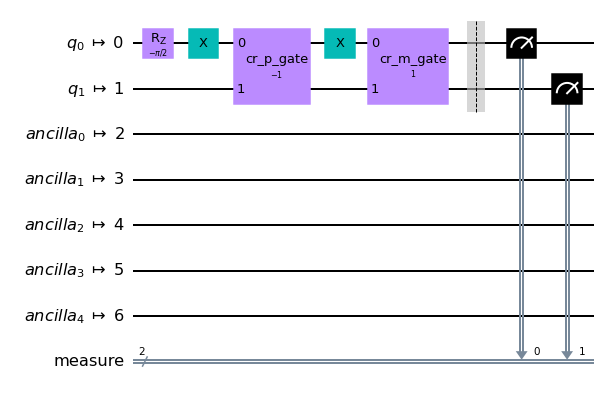

In [12]:
tc[0].draw('mpl')

In [13]:
# draw(sched[4], backend=backend, time_range=[0, 1000], disable_channels=[MeasureChannel(q1), MeasureChannel(q2)])

In [14]:
i = 1
identifier = F"(({max_cr_amplitude}),{num_amps})"

In [15]:
job = backend.run(tc, job_name=F"cr_amp_exp_{identifier}", shots=2048)
job_id = job.job_id()
print(job.job_id())

618a94942bf2b36efea11649


In [16]:
# 11/8/2021 - amplitude experiments
# ibm_lagos job (9:45~ am) - 6189380f1452777724117b88
# ibmq_jakarta job (10:00~ am) - 61893b88902694642fd98881
# ibmq_jakarta (10:30~ am) - 6189411bc45f2664c31517c5
# ibmq_jakarta (10:51~ am) - 61894761ad7fa029bcd1440f * best results so far (sweeping from (-1.0, 1.0, 70))
# ibmq_jakarta (11:23~ am) - 61894f14ad7fa0ed2ad14439
# ibmq_jakarta (12:47 pm) - 618962b8ce94116c106c071e (-1.0, 1.0, 70) - CRgate looks more like ibm
# ibmq_montreal (11:18~ am) - 61894de8c45f2661c61517fb
# ibmq_toronto (11:27~ am) - 61894fdab3f4906ac760bf9e
# ibmq_toronto (11:33~ am) - 61895180145277452e117c10

# 11/9/2021 - amplitude experiments
# ibmq_jakarta (10:33~ am) - 618a94942bf2b36efea11649 (-1.0, 1.0, 70)
# job_id = "618962b8ce94116c106c071e"
results = backend.retrieve_job(job_id).result()


In [17]:
count_dict = results.get_counts()
print(count_dict)

[{'00': 776, '01': 18, '10': 1245, '11': 9}, {'00': 826, '01': 16, '10': 1191, '11': 15}, {'00': 812, '01': 20, '10': 1202, '11': 14}, {'00': 818, '01': 21, '10': 1196, '11': 13}, {'00': 889, '01': 22, '10': 1123, '11': 14}, {'00': 906, '01': 13, '10': 1118, '11': 11}, {'00': 944, '01': 23, '10': 1065, '11': 16}, {'00': 963, '01': 11, '10': 1063, '11': 11}, {'00': 1068, '01': 12, '10': 957, '11': 11}, {'00': 1083, '01': 18, '10': 933, '11': 14}, {'00': 1115, '01': 14, '10': 907, '11': 12}, {'00': 1139, '01': 27, '10': 872, '11': 10}, {'00': 1159, '01': 19, '10': 860, '11': 10}, {'00': 1249, '01': 22, '10': 763, '11': 14}, {'00': 1286, '01': 26, '10': 730, '11': 6}, {'00': 1301, '01': 17, '10': 722, '11': 8}, {'00': 1394, '01': 17, '10': 630, '11': 7}, {'00': 1407, '01': 21, '10': 614, '11': 6}, {'00': 1435, '01': 23, '10': 585, '11': 5}, {'00': 1495, '01': 22, '10': 524, '11': 7}, {'00': 1563, '01': 26, '10': 455, '11': 4}, {'00': 1588, '01': 23, '10': 432, '11': 5}, {'00': 1628, '01':

In [18]:
def cr_fit_3rd_order_perturbation(x, c1, c2):
    fx = c1*x - c2*x**3
    return np.cos(2 * np.pi * fx)

def rough_amp_objective(x, params, opt_phase):
    fx = params[0] * x - params[1] * x**3
    return np.abs(opt_phase / 2 / np.pi - fx)

In [19]:
exp_z = np.zeros_like(cr_amps)
for cind in range(len(cr_amps)):
    exp_z[cind] = expectation_val(count_dict[cind], mem_ind=mem_ind)
# print(exp_z)
valid_inds = np.where(np.abs(cr_amps) < 1.0)[0]
params, _ = opt.curve_fit(cr_fit_3rd_order_perturbation, xdata=cr_amps[valid_inds], ydata=exp_z[valid_inds])
cr_pi2_amp = opt.minimize(rough_amp_objective, x0=0, bounds=[(0, 1)], args=(params, 0.5 * np.pi)).x[0]

In [20]:
print(cr_pi2_amp)

0.7511834318926244


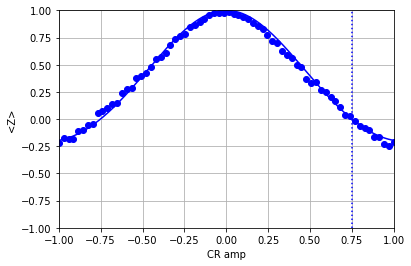

In [69]:
x_interp = np.linspace(cr_amps[0], cr_amps[-1], 1000)
plt.plot(cr_amps, exp_z, 'o', color='b')
plt.plot(x_interp, cr_fit_3rd_order_perturbation(x_interp, *params), color='b')
plt.plot([cr_pi2_amp, cr_pi2_amp], [-1, 1], 'b:')
plt.xlim(-max_cr_amplitude, max_cr_amplitude)
plt.ylim(-1, 1)
plt.xlabel('CR amp')
plt.ylabel('<Z>')
plt.grid()
plt.savefig("amplitude_calibration")

In [42]:
cr_params = extract_cr_params(cx_sched)
cr_params["cr_amp"] = cr_pi2_amp
cr_params["cancel_amp"] = 0.0

max_phase = np.pi
num_phases = 20
cr_phases = np.linspace(-max_phase, max_phase, num_phases)


In [43]:
# for phase in cr_phases:
#     print(cr_pi2_amp * np.exp(-1j*phase))
#     print(cr_pi2_amp * np.exp(-1j*(phase+np.pi)))

In [44]:
print(cr_params)

{'duration': 368, 'width': 112, 'sigma': 64, 'cr_amp': 0.7511834318926244, 'channel': ControlChannel(0), 'cancel_amp': 0.0}


In [45]:
phase_exp_circuits, phase_exp_inst_maps = build_phase_experiment_circuits(backend, q1, q2, cr_phases, cr_params)


(-0.7511834318926244+9.199343854398263e-17j)
(0.7511834318926244+0j)
(-0.7104822415638985+0.24390886161088773j)
(0.7104822415638985-0.24390886161088765j)
(-0.5927892760938767+0.46138641343030323j)
(0.5927892760938768-0.4613864134303031j)
(-0.4108583944857543+0.6288655882067083j)
(0.41085839448575434-0.6288655882067083j)
(-0.1844046307102582+0.7281974186459289j)
(0.18440463071025828-0.7281974186459289j)
(0.0620322361353533+0.7486177596277214j)
(-0.062032236135353205-0.7486177596277214j)
(0.30174694766638266+0.6879137503524715j)
(-0.30174694766638255-0.6879137503524715j)
(0.5087626953314544+0.5526636121449057j)
(-0.5087626953314544-0.5526636121449057j)
(0.6606461106907705+0.3575237961019367j)
(-0.6606461106907705-0.35752379610193674j)
(0.7409382689761391+0.1236407291980421j)
(-0.7409382689761391-0.12364072919804218j)
(0.7409382689761391-0.1236407291980421j)
(-0.7409382689761391+0.123640729198042j)
(0.6606461106907705-0.3575237961019367j)
(-0.6606461106907705+0.3575237961019366j)
(0.50876

In [46]:
y0 = deepcopy(phase_exp_circuits)
y1 = []
for circ in y0:
    y1_circ = QuantumCircuit(2)
    y1_circ.x(0)
    y1_circ += circ
    y1.append(y1_circ)

<ipython-input-46-95e79d3478e8>:6: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  y1_circ += circ
C:\Users\Zachary\anaconda3\envs\NewestPythonQiskit\lib\site-packages\qiskit\circuit\quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


In [51]:
phase_exp_circuits = y0+y1
tc = transpile(phase_exp_circuits, backend, initial_layout=[q1, q2])
identifier = F"(({max_phase}),{num_phases})"

In [52]:
job = backend.run(tc, job_name=F"cr_amp_exp_{identifier}", shots=2048)
job_id = job.job_id()
print(job.job_id())

618aa15deb641130bbbb5c4f


In [53]:
# 11/9/2021 - phase experiments
# ibmq_jakarta (11:27~ am) - 618aa15deb641130bbbb5c4f (-np.pi, np.pi, 20)
results = backend.retrieve_job(job_id).result()


In [54]:
count_dict = results.get_counts()
print(count_dict)

[{'00': 1013, '01': 16, '10': 1005, '11': 14}, {'00': 702, '01': 9, '10': 1326, '11': 11}, {'00': 419, '01': 13, '10': 1593, '11': 23}, {'00': 232, '01': 13, '10': 1777, '11': 26}, {'00': 93, '01': 5, '10': 1930, '11': 20}, {'00': 59, '01': 7, '10': 1964, '11': 18}, {'00': 121, '01': 12, '10': 1896, '11': 19}, {'00': 240, '01': 11, '10': 1772, '11': 25}, {'00': 441, '01': 17, '10': 1569, '11': 21}, {'00': 741, '01': 14, '10': 1273, '11': 20}, {'00': 1057, '01': 13, '10': 964, '11': 14}, {'00': 1396, '01': 26, '10': 612, '11': 14}, {'00': 1639, '01': 14, '10': 389, '11': 6}, {'00': 1886, '01': 14, '10': 140, '11': 8}, {'00': 1991, '01': 21, '10': 29, '11': 7}, {'00': 1971, '01': 21, '10': 49, '11': 7}, {'00': 1870, '01': 15, '10': 155, '11': 8}, {'00': 1620, '01': 20, '10': 401, '11': 7}, {'00': 1343, '01': 15, '10': 676, '11': 14}, {'00': 1006, '01': 22, '10': 1006, '11': 14}, {'00': 40, '01': 834, '10': 45, '11': 1129}, {'00': 34, '01': 1171, '10': 40, '11': 803}, {'00': 57, '01': 148

In [55]:
print(len(count_dict))

40


In [56]:
def cos_fit_00(x, a, b):
    return a * np.cos(x - b + np.pi)

def cos_fit_10(x, a, b):
    return a * np.cos(x - b)

In [67]:
exp_y0 = np.zeros_like(cr_phases)
exp_y1 = np.zeros_like(cr_phases)

results_y0 = count_dict[:20]
results_y1 = count_dict[20:]

for cind in range(len(cr_phases)):
    exp_y0[cind] = expectation_val(results_y0[cind], mem_ind=mem_ind)
    exp_y1[cind] = expectation_val(results_y1[cind], mem_ind=mem_ind)
# print(exp_y0)
# print(exp_y1)

params0, _ = opt.curve_fit(cos_fit_00, xdata=cr_phases, ydata=exp_y0, bounds=([0, -np.pi], [1, np.pi]))
params1, _ = opt.curve_fit(cos_fit_10, xdata=cr_phases, ydata=exp_y1, bounds=([0, -np.pi], [1, np.pi]))

phi_opt = (params0[1] + params1[1]) / 2
print(phi_opt)

-1.4935498659233146


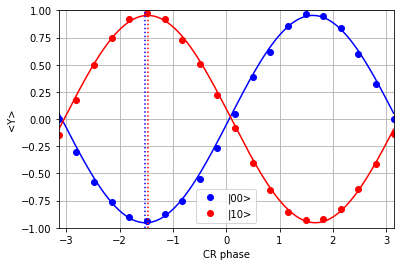

In [68]:
x_interp = np.linspace(cr_phases[0], cr_phases[-1], 1000)
plt.plot(cr_phases, exp_y0, 'o', color='b', label='|00>')
plt.plot(cr_phases, exp_y1, 'o', color='r', label='|10>')
plt.plot(x_interp, cos_fit_00(x_interp, *params0), 'b')
plt.plot(x_interp, cos_fit_10(x_interp, *params1), 'r')
plt.plot([params0[1], params0[1]], [-1, 1], 'b:')
plt.plot([params1[1], params1[1]], [-1, 1], 'r:')
plt.xlim(cr_phases[0], cr_phases[-1])
plt.ylim(-1, 1)
plt.xlabel('CR phase')
plt.ylabel('<Y>')
plt.grid()
plt.legend()
plt.savefig("phase_calibration")